# TensorFlow Assignment: Playing with GANs

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Alex Lew

## Imports and helper functions

In [3]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

def variables_from_scope(scope_name):
    """
    Returns a list of all variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope_name)

def visualize_row(images, img_width=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a column
    in a plot, using `cmap` to map from numbers to colors.
    """
    im = np.reshape(images, [-1, img_width])
    plt.figure()
    plt.imshow(im, cmap=cmap)
    plt.show()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Interpolating between images

As our “random noise” varies, so does the image our GAN generates. Perturbing the random input a little bit should perturb the image a little bit. This means that by taking small steps from one input to another, we can “animate” the transition from the image our GAN draws for the first to the one it draws for the second. Generate two random samples from a GAN, and interpolate between them (with, say, 100 steps).

In particular:
1. Train a GAN (using code from class).
2. Generate some noise `= np.random.uniform(-1, 1, [10, 32])` (for instance).
3. Get some fake images out using `sess.run(fake_X, {z: noise})`
4. Visualize them using `visualize_row()` and choose two images you like (say, image 1 and 3). Pull out `start` and `end` noise vectors (e.g., `start = noise[0]` and `end = noise[2]`).
5. Generate a list of ten vectors `steps = [..., ..., ...]`, where entry `i` is `i*10`% of the way from start to end.
6. `np.concatenate(steps)` (with appropriate axis) to get a new noise matrix. Run the GAN on that noise matrix, and visualize the 10 images you get as results.

Iter [       0] Time [0.1672] d_loss [1.4499]


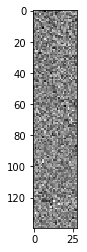

Iter [    1000] Time [4.1186] d_loss [0.0115]


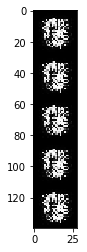

Iter [    2000] Time [8.1888] d_loss [0.0620]


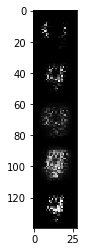

Iter [    3000] Time [12.2352] d_loss [0.0318]


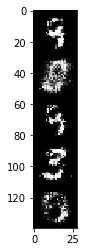

Iter [    4000] Time [16.2524] d_loss [0.2105]


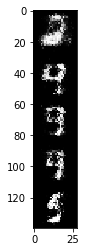

Iter [    5000] Time [20.3026] d_loss [0.1198]


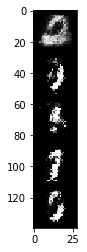

Iter [    6000] Time [24.0881] d_loss [0.2229]


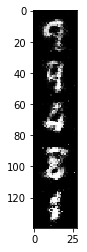

Iter [    7000] Time [28.1911] d_loss [0.3111]


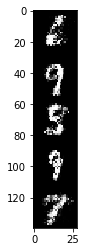

Iter [    8000] Time [32.1471] d_loss [0.3450]


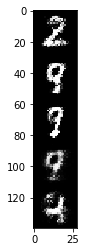

Iter [    9000] Time [36.1939] d_loss [0.3304]


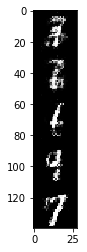

Iter [    9999] Time [40.3011] d_loss [0.4064]


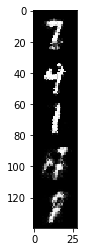

In [4]:
# THIS CELL CONTAINS UNMODIFIED CODE FROM CLASS

# Graph parameters
z_dimension = 32
intermediate_layer_size = 128
image_size = 784
# Training parameters
batch_size = 50
iterations = 10000
# Generator
def generator(z):
    hidden_layer = tf.layers.dense(z, intermediate_layer_size, activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, activation=tf.sigmoid)
    return fake_X
# Discriminator
def discriminator(images):
    hidden_layer = tf.layers.dense(images, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2", activation=tf.sigmoid)
    return D_output

# Graph
tf.reset_default_graph()

# Placeholders
real_X = tf.placeholder(tf.float32, [None, image_size])
z = tf.placeholder(tf.float32, [None, z_dimension])

# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator(z)

# Discriminator
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X)
    scope.reuse_variables()
    d_on_real = discriminator(real_X)

g_loss = -tf.reduce_mean(tf.log(d_on_fake))
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1. - d_on_fake))

optimize_d = tf.train.AdamOptimizer().minimize(d_loss, var_list=variables_from_scope("discriminator"))
optimize_g = tf.train.AdamOptimizer().minimize(g_loss, var_list=variables_from_scope("generator"))

initialize_all = tf.global_variables_initializer()

# Train the GAN.
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

def next_feed_dict():
    return {real_X: mnist.train.next_batch(batch_size)[0],
            z:      make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    sess.run(optimize_g, feed_dict=next_feed_dict())
    _, loss = sess.run([optimize_d, d_loss], feed_dict=next_feed_dict())

    if t % 1000 == 0 or t+1 == iterations:
        fake_data = sess.run(fake_X, feed_dict={z: make_noise()})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:5])

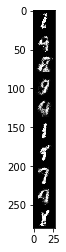

In [13]:
# Visualize some samples from the generator.
noise_sample = np.random.uniform(-1, 1, [10, z_dimension])
fake_images = sess.run(fake_X, {z: noise_sample})
visualize_row(fake_images)

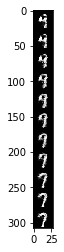

In [18]:
# Choose two samples -- we'll do the second and eighth.
start = noise_sample[1].reshape([1, z_dimension]) # a 9
end   = noise_sample[7].reshape([1, z_dimension]) # a 7
# Compute a matrix where each row is a "step" along the path
# from start to end. 0% of the way, 10% of the way, etc.
# There are 11 total steps: 0, 10, 20, ..., 90, 100%.
steps = np.concatenate([start + (i/10 * (end-start)) for i in range(11)])
# Run and visualize.
interpolated_images = sess.run(fake_X, {z: steps})
visualize_row(interpolated_images)

### Conditioning on the class label

In class, we drew a random noise vector $z$, and passed it into the Generator. This gave us very little control over the images we generated. Suppose we wanted to be able to generate a random image of a two, or of a three. In other words, we want to train the model to know how to draw whatever digit we tell it to. How could you alter the training procedure to make this work? Implement a conditional GAN, and use it to generate twos or threes.

In particular,

1. Modify the code from class to take placeholder inputs (real images and z values) that are 10 elements longer.
2. Modify the next_feed_dict to concatenate labels (one-hot, ten-dimensional) to the noise inputs and image inputs.
3. Train the GAN.
4. Try making the GAN generate a few ones, then a few threes, by concatenating `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]` or `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`, say, to your noise vectors. How does it do?

Iter [       0] Time [0.0180] d_loss [1.6927]


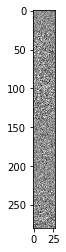

Iter [    1000] Time [4.3623] d_loss [0.0146]


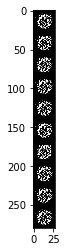

Iter [    2000] Time [8.5824] d_loss [0.0049]


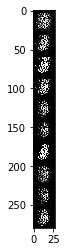

Iter [    3000] Time [12.8402] d_loss [0.0614]


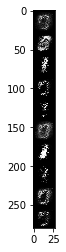

Iter [    4000] Time [17.3291] d_loss [0.2067]


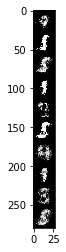

Iter [    5000] Time [21.4572] d_loss [0.1131]


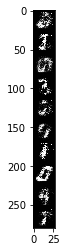

Iter [    6000] Time [26.0022] d_loss [0.4346]


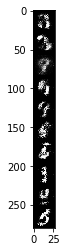

Iter [    7000] Time [30.8808] d_loss [0.2673]


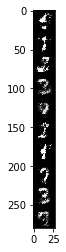

Iter [    8000] Time [35.7672] d_loss [0.3551]


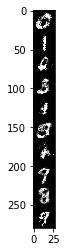

Iter [    9000] Time [40.6282] d_loss [0.4078]


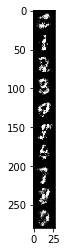

Iter [    9999] Time [45.1174] d_loss [0.4404]


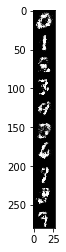

Iter [   10000] Time [45.2248] d_loss [0.5754]


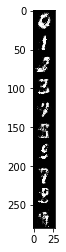

Iter [   11000] Time [49.9417] d_loss [0.9222]


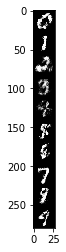

Iter [   12000] Time [54.6993] d_loss [0.4889]


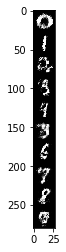

Iter [   13000] Time [59.3656] d_loss [0.5120]


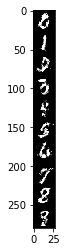

Iter [   14000] Time [64.5166] d_loss [0.8389]


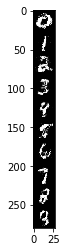

Iter [   15000] Time [71.2421] d_loss [0.5265]


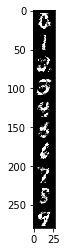

Iter [   16000] Time [77.2247] d_loss [0.8529]


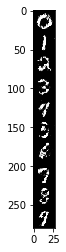

Iter [   17000] Time [81.9370] d_loss [0.6253]


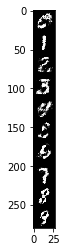

Iter [   18000] Time [86.7748] d_loss [0.9701]


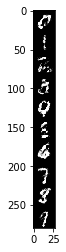

Iter [   19000] Time [91.5374] d_loss [0.7742]


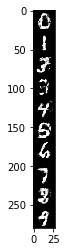

In [25]:
# MOSTLY UNMODIFIED CODE; 
# modified sections are highlighted with comments

tf.reset_default_graph()

# Placeholders
# CHANGES HERE: Change each placeholder to expect 10 extra nums for the label
real_X = tf.placeholder(tf.float32, [None, image_size+10])
z = tf.placeholder(tf.float32, [None, z_dimension+10])

# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator(z)

# Discriminator
with tf.variable_scope("discriminator") as scope:
    # CHANGES HERE: append labels to fake images before
    # passing to discriminator.
    labels = z[:, -10:] # pull out the last ten columns of z, as labels
    fakes_with_labels = tf.concat([fake_X, labels], axis=1) # concat with fake images
    d_on_fake = discriminator(fakes_with_labels)
    scope.reuse_variables()
    d_on_real = discriminator(real_X) # already has labels

g_loss = -tf.reduce_mean(tf.log(d_on_fake))
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1. - d_on_fake))

optimize_d = tf.train.AdamOptimizer().minimize(d_loss, var_list=variables_from_scope("discriminator"))
optimize_g = tf.train.AdamOptimizer().minimize(g_loss, var_list=variables_from_scope("generator"))

initialize_all = tf.global_variables_initializer()

# Train the GAN.
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

def next_feed_dict():
    # CHANGES HERE: add labels to the noise and images we pass to sess.run(...)
    batch_X, batch_Y = mnist.train.next_batch(batch_size)
    X_with_labels = np.concatenate([batch_X, batch_Y], axis=1)
    z_with_labels = np.concatenate([make_noise(), batch_Y], axis=1)
    return {real_X: X_with_labels,
            z:      z_with_labels}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(20000):
    sess.run(optimize_g, feed_dict=next_feed_dict())
    _, loss = sess.run([optimize_d, d_loss], feed_dict=next_feed_dict())

    if t % 1000 == 0 or t+1 == iterations:
        # CHANGES HERE: instead of visualizing 5 random digits, we visualize
        # a random sample of each digit from 0 to 9.
        # First, the ten labels we'll ask for:
        labels = np.eye(10) # the 10x10 identity matrix ("eye" is a pun for I)
        # Add these labels to ten rows of random noise
        z_with_labels = np.concatenate([np.random.uniform(-1, 1, [10, 32]), labels], axis=1)
        # Generate the images
        fake_data = sess.run(fake_X, feed_dict={z: z_with_labels})
        # Print / visualize
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data)